In [ ]:
!nvidia-smi

Fri Jul 16 13:07:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Coursework2

/content/drive/MyDrive/Coursework2


In [5]:
#  Install MTCNN
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 7.8 MB/s 


In [6]:
import os
import cv2
import random
import numpy as np
from PIL import Image
from imutils import paths
from sklearn.svm import SVC
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, LabelEncoder
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input

In [ ]:
import mtcnn
# Confirm MTCNN was installed correctly?
print('Version:', mtcnn.__version__)

Version: 0.1.0


##$===============$ Prepare Datasets $===============$

In [37]:
def extract_face(filename, size = (160, 160)):
    img = Image.open(filename)
    #   Convert to RGB to remove alpha channel
    img = img.convert('RGB')
    #   Convert image to array
    img = np.array(img)
    #   Create a detector by using defaut weights
    detector = MTCNN()
    #   Detect face in image
    result = detector.detect_faces(img)
    #   Extract the bounding box from face
    x, y, width, height = result[0]['box']
    x1, y1 = abs(x), abs(y)
    x2, y2 = x1 + width, y1 + height
    #   Extract the face from co-ordinate of the bounding box
    face = img[y1:y2, x1:x2]
    #   Resize face to FaceNet model require with size (160, 160)
    face = cv2.resize(face, size)
    face_arr = np.array(face)
    return face_arr 

In [48]:
img_path = list(paths.list_images('Datasets'))
random.shuffle(img_path)

In [49]:
labels_name = [p.split(os.path.sep)[-2] for p in img_path]

In [ ]:
#   Create datasets
X_data = []
for path in img_path:
    face = extract_face(path)
    X_data.append(face)

In [51]:
#   Generate labels
lab = LabelEncoder()
lab.fit(labels_name)
labels = lab.fit_transform(labels_name)

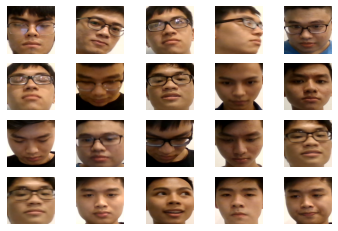

In [ ]:
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_data[i])
    plt.axis('off');

In [ ]:
#   Save dataset
np.savez("Datasets.npz", x = X_data, y = labels)

##$=============$ Create Face Embedding $=============$

In [9]:
#   Load Datasets from file.npz
Data = np.load("Datasets.npz")
X_data = Data['x']
labels = Data['y']

In [ ]:
#   Load Pre-train model (FaceNet) to generate embedding vectors
model = load_model('facenet_keras.h5')

In [11]:
def get_embedding(model, face):
    face = face.astype('float32')
    # Standardize pixel values across channels (global)
    mean, std = face.mean(), face.std()
    face = (face - mean) / std
    # Transform face into one sample
    samples = np.expand_dims(face, axis = 0)
    # Make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [12]:
#   Generate embedding vector
embb_vecs = []
for face in X_data:
    vect = get_embedding(model, face)
    embb_vecs.append(vect)
embb_vecs = np.array(embb_vecs)

In [13]:
#   Split into Train & Test datasets
X_train, X_test, Y_train, Y_test = train_test_split(embb_vecs, labels, test_size = 0.2, random_state = None)
print(X_train.shape)
print(X_test.shape)

(476, 128)
(119, 128)


##$============$ Perform Face Classification $============$

In [ ]:
# Normalize embbeding vectors
in_encoder = Normalizer(norm = 'l2')
X_train = in_encoder.transform(X_train)
X_test = in_encoder.transform(X_test)

In [17]:
# Fit model
Model = SVC(kernel = 'linear', probability = True)
Model.fit(X_train, Y_train)
# Predict
yhat_train = Model.predict(X_train)
yhat_test = Model.predict(X_test)
# score
score_train = accuracy_score(Y_train, yhat_train)
score_test = accuracy_score(Y_test, yhat_test)

In [ ]:
#   Evaluate model
print(f'Accuracy of TrainSet: {round(score_train * 100, 2)}%')
print(f'Accuracy of TestSet: {round(score_test * 100, 2)}%')

Accuracy of TrainSet: 100.0%
Accuracy of TestSet: 100.0%


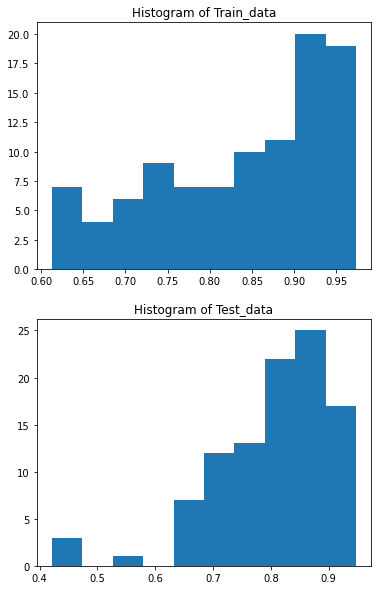

In [35]:
test_dataset = random.choices(X_test, k = 100)
probs_test = Model.predict_proba(test_dataset)
train_dataset = random.choices(X_train, k = 100)
probs_train = Model.predict_proba(train_dataset)

train = []
test = []
for prob in probs_train:
  train.append(prob.max())
for prob in probs_test:
  test.append(prob.max())

plt.figure(figsize=(6, 10))

plt.subplot(2,1,1)
plt.hist(train)
plt.title('Histogram of Train_data')
plt.subplot(2,1,2)
plt.hist(test)
plt.title('Histogram of Test_data')

plt.show()

$=>$ Choose confidence: 0.4

In [ ]:
# Save SVC model
from sklearn.externals import joblib
joblib.dump(Model, 'model.h5')

## Test model with more image

In [38]:
Test_path = list(paths.list_images('TestSet'))
random.shuffle(Test_path)

#   Generate face
faces = []
for path in Test_path:
    face = extract_face(path)
    faces.append(face)

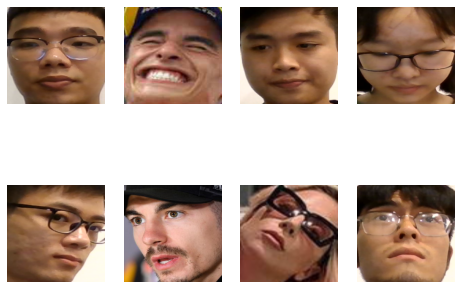

In [39]:
num_face = len(faces)
plt.figure(figsize = (8, 6))
for i in range(num_face):
    plt.subplot(2, num_face/2, i+1)
    plt.imshow(faces[i])
    plt.axis('off');

In [40]:
from sklearn.externals import joblib
#   Load SVC model
Model = joblib.load('model.h5')
#   Load FaceNet model
FN_model = load_model('facenet_keras.h5')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#   Generate Embbeding
embb_vecs = []
for face in faces:
    vector = get_embedding(FN_model, face)
    embb_vecs.append(vector)
embb_vecs = np.array(embb_vecs)

In [42]:
# Normalize embbeding vectors
in_encoder = Normalizer(norm = 'l2')
data = in_encoder.transform(embb_vecs)

In [43]:
Expec_name = [p.split(os.path.sep)[-1][0:-4] for p in Test_path]

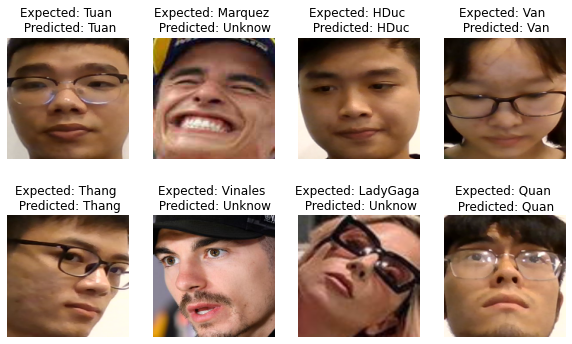

In [52]:
#   Predict
yhat = Model.predict(data)

#   Probability
yhat_proba = Model.predict_proba(data)
probs = [yhat_proba[i, yhat[i]] for i in range(len(yhat_proba))]

# Plot predicted image
num_img = len(data)
plt.figure(figsize = (10, 6))
for i in range(num_img):
    plt.subplot(2, num_img/2, i+1)
    plt.imshow(faces[i])
    if probs[i] >= 0.4:
        name_pred = lab.inverse_transform([yhat[i]])
        plt.title(f'Expected: {Expec_name[i]} \n Predicted: {name_pred[0]}')
    else:
        plt.title(f'Expected: {Expec_name[i]} \n Predicted: Unknow')
    plt.axis('off');